# Esercitazione 6

Nella cartella dell'esercitazione sono presenti:
- La cartella `ISING_1D`.
- La cartella con i dati della termalizzazione.

<img src="Menu.png">

Nella cartella `ISING_1D` sono presnti:
- Le cartelle `Metropolis` e `Gibbs` con i file di output delle simulazioni.
- Il file della configurazione finale.
- Il file di *input*.
- Il __Makefile__.
- I file del codice __Monte_Carlo_ISING_1D__.
- Il codice *python* per far andare la sequenza di simulazioni.
- I file per la classe __Random__.

<img src="Menu1.png">

Queste sono variabili e librerie necessarie per il codice.

In [7]:
import numpy as np
import matplotlib.pyplot as plt 

obs=[
    "ene",
    "heat",
    "chi",
    "mag"
]

titles=[
    f"Energia Interna\n$h=0$",
    f"Capacità Termica\n$h=0$",
    f"Suscettibilità Magnetica\n$h=0$",
    f"Magnetizzazione\n$h=0.02$"
]

ytitle=[
    r"$\Delta_U$",
    r"$\Delta_C$",
    r"$\Delta_\chi$",
    r"$\Delta_m$"
]

N= 16

## 1 Modello di Ising

Il modello di Ising è un modello della meccanica statistica utilizzato per studiare diversi sistemi, ad esempio la magnetizzazione di un ferro magnete.  Consiste in un sistema di spin $N$-dimensionale descritto da  un'*Hamiltoniana*, con donizioni periodiche, quindi $s_{N+1}=s_1$.  Noi studieremo il caso monodimensionale, quindi l'*Hamiltoniana* diventa:
$$
H=-J\sum_{i=1}^N s_i\,s_{i+1}-\frac{h}{2}\sum_{i=1}^N(s_i+s_{i+1})
$$

Essendo un sistema ferromagnetico i valori di $s_i\in\{-1,1\}$ e $J>0$. 

Per semplificare poniamo:
- $k_B=1$ .
- $\mu_B=1$ .

Nel nostro caso possiamo trovare analiticamente la soluzione per la funzione dei partizione $Z$:
$$
Z=\sum_{\{s_i\}}(-\beta\,H)=\lambda_1^N+\lambda_2^N
$$
con $\lambda_{1,2} = e^{\beta J} \cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$ e $\beta=\frac{1}{k_B\,T}$.

Da $Z$ possiamo ricavare l'*energia libera di Gibbs*:
$$
A=-k_B\,T\ln{Z}
$$

Da queste possiamo ricavare tutte le altre grandezze termodinamiche.

### 1.1 Algoritmi di Campionamento

Per trovare la funzione di partizione serve trovare un algoritmo per campionare lo spazio degli stati.  Non ne useremo due:
1. Metropolis.
2. Gibbs.

#### 1.1.1 Algoritmo di Metropolis

L'__algoritmo di Metropolis__ consiste in prendere un campione e cambiare il suo stato ed accettare la "*mossa*" in base alla probabilità $q(x|y)=\min[1,A(x|y)]$, dove:
$$
A(x|y)=\frac{T(x|y)\,p(x)}{T(y|x)\,p(y)}
$$
con $T(x|y)$ la probabilità che il sistema passi da $x$ a $y$ e $p(x)$ la probabilità di trovarsi in $x$.

La comodità di questo algoritmo è che non serve che le probabilità siano normalizzate.

Nel __modello di Ising__ selezioniamo casualmente uno spin e lo giriamo ($\pm 1 \to \mp 1$) con probabilità $q(\Delta E)=\min{\left[1,e^{-\beta\,\Delta E}\right]}$.

#### 1.1.2 Algoritmo di Gibbs

L'__algoritmo di Gibbs__ preso un sistema con più variabili cambiamo lo stato di una di queste variabili mantenedole tutte costanti tranne una la quale, il nuovo stato, viene estratto dalla probabilità condizionale dello stato attuale rispetto agli altri.

In questo caso le mosse vengono sempre accettate, ma neanche con __Gibbs__ c'è bisogno di sapere la funzione di partizione.

Nel __modello di Ising__ estrarremo le mosse dalla probabilità:
$$
p(s_k'=\pm1|\{s_j:j\neq k\})=\frac{1}{1+exp(-\beta\,\Delta E_{s_k=\pm1\to s_k=\mp1})}
$$

### 1.2 Simulazione

Utilizzando questi algoritmi possiamo campionare lo spazio degli stati per determinare le grandezze termodinamiche:
1. Energia interna: $U(N,T) = \langle H \rangle_{h=0}$
2. Capacità termica: $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. Sucettibilità magnetica: $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. Magnetizzazione: $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

Confronteremo questi vaolri con quelli ottenuti analiticamente nel range di $T\in[0.5,2]$.

<font color=red>N.B.</font> Anche in questa esercitazione è necessaria la termalizzazione del sistema, per velocizzare questo processo inizieremo con una configurazione casuale alla temperatura più alta per poi abbassare la temperatura ripartendo dall'ultima configurazione della temperatura precedente.

#### 1.2.1 Risultati Analitici

Analitiamente si arriva ai seguenti risultati.

__Energia Interna__
$$
\frac{U(N,T)}{N}\underset{h=0}=  -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$
__Capacità Termica__
$$
\frac{C(N,T)}{N} \underset{h=0}= k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$
__Magnetizzazione__
$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\;\cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$
__Sucettibilità Magnetica__
$$
\chi(N,T)\underset{h=0}= \beta \left[ \left\langle \left( \sum_{i=1,N}s_i \right)^2 \right\rangle \right] = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

In [17]:
T=np.linspace(0.5,2,N)

#Ricaviamo i risultati in maniera analitica
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
h=0.02 #Campo esterno

e = -J*( th + ch*thN )/( 1 + thN )
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

l1 = np.exp(beta*J)*np.cosh(beta*h)+np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))
l2 = np.exp(beta*J)*np.cosh(beta*h)-np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))
Z = l1**Ns + l2**Ns
M = (np.exp(beta*J)*np.sinh(beta*h)*((l1**(Ns-1))*(1+np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J))) 
        + (l2**(Ns-1))*(1-np.exp(beta*J)*np.cosh(beta*h)/np.sqrt(np.exp(2*beta*J)*np.cosh(beta*h)*np.cosh(beta*h)-2*np.sinh(2*beta*J)))))/(Z)

appo=[e,heat,X,M]

#### 1.2.2 Termalizzazione

Osserviamo per i due algoritmi la termalizzazione in due casi, con entrambi gli algoritmi.

Il __primo caso__ partiamo da una *configurazione casuale* e facciamo una simulazione con $T=2$.  Questo per osservare quanto ci mette il sistema a termalizzare da una configurazione casuale.

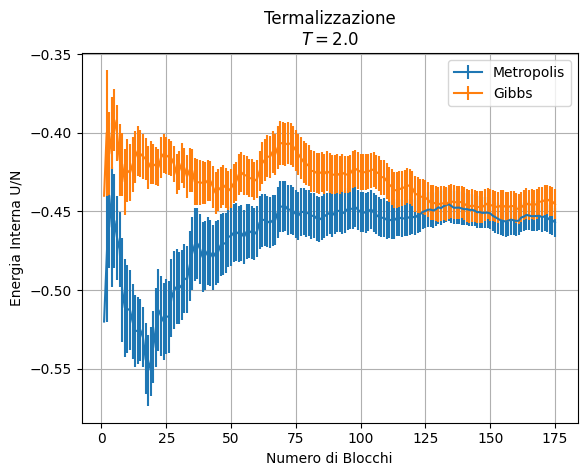

In [8]:
term1M=np.loadtxt("Termalization/metro_2.0.dat")
term1G=np.loadtxt("Termalization/gibbs_2.0.dat")

plt.errorbar(term1M[:,0],term1M[:,2],yerr=term1M[:,3],label="Metropolis")
plt.errorbar(term1G[:,0],term1G[:,2],yerr=term1G[:,3],label="Gibbs")

plt.grid(True)
plt.legend()
plt.ylabel("Energia Interna U/N")
plt.xlabel("Numero di Blocchi")
plt.title(f"Termalizzazione\n$T=2.0$")

plt.show()

Osserviamo che il metodo di *Metropolis* termalizza dopo circa $50$ step, invece *Gibbs* ci mette circa $125$ step.  Inoltre, possiamo vedere che, una volta termalizzato il sistema, otteniamo risultati compatibili con entrambi i metodi.

Il __secondo caso__ guardiamo quanto ci mette il sistema a termalizzarsi partendo dalla configurazione precedente.  In questo caso studiamo solo il caso in cui $T=0.5$ e parte da una configurazione termalizzata a $T_0=0.6$ .

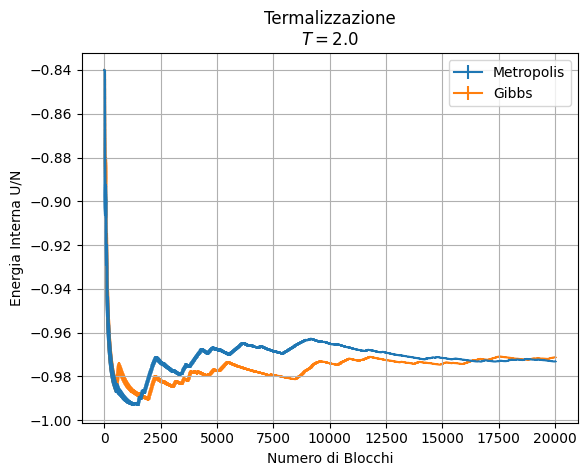

In [9]:
term1M=np.loadtxt("Termalization/metro_0.5.dat")
term1G=np.loadtxt("Termalization/gibbs_0.5.dat")

plt.errorbar(term1M[:,0],term1M[:,2],yerr=term1M[:,3],label="Metropolis",zorder=2)
plt.errorbar(term1G[:,0],term1G[:,2],yerr=term1G[:,3],label="Gibbs",zorder=1)

plt.grid(True)
plt.legend()
plt.ylabel("Energia Interna U/N")
plt.xlabel("Numero di Blocchi")
plt.title(f"Termalizzazione\n$T=2.0$")

plt.show()

Osserviamo che anche in questo caso che il sistema inizia a termalizzare, per *Metropolis* a $7500$ step invece per *Gibbs* a $10000$ step.  In questo caso la termalizzazione è molto pìu lunga visto che la probabilità di invertire uno spin è molto basso.

Grazie a queste osservazioni possiamo far termalizzare il sistema con *Metropolis*, visto che più veloce, ed usare $10000$ step per essere sicuro che le forti oscillazioni iniziali non influiscano sulla media.

#### 1.2.3 Risultati delle Simulazioni

Osserviamo il risultato delle simulazioni di $16$ temperature in $100$ blocchi da $10000$ step l'uno.

__Metropolis__

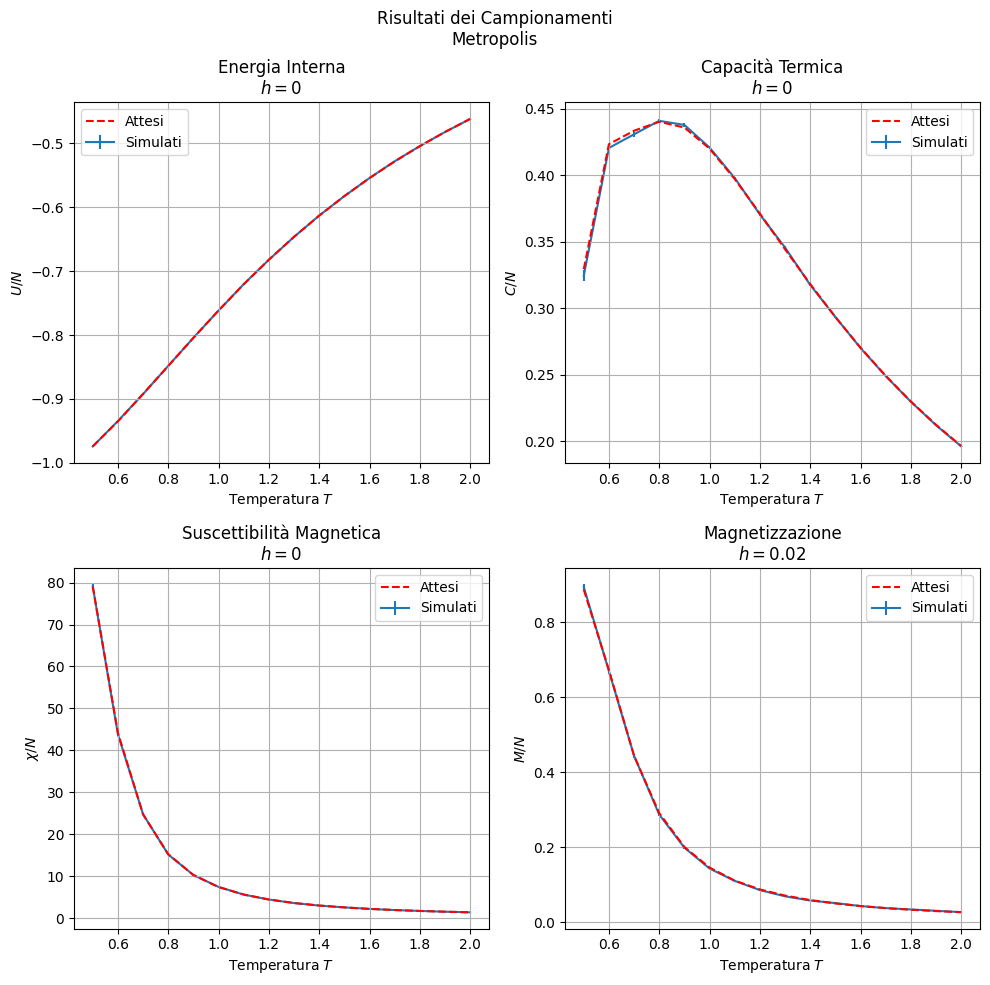

In [23]:
metro=np.array([
    np.array([np.loadtxt("ISING_1D/Metropolis/output_"+obs[j]+"_"+ str(np.round(T[i],1)) +".dat") for i in range(N)])
    for j in range(4)
])

fig, ax=plt.subplots(2,2,figsize=(10,10))
ax=np.reshape(ax,4)

symbles=[
    r"$U/N$",
    r"$C/N$",
    r"$\chi/N$",
    r"$M/N$"
]

for i in range(4):
    ax[i].errorbar(T,metro[i,:,-1,2],yerr=metro[i,:,-1,3],label="Simulati",zorder=1)
    ax[i].plot(T,appo[i],label="Attesi",color='red', linestyle='dashed',zorder=2)

    ax[i].set(xlabel=r"Temperatura $T$", ylabel=symbles[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid(True)

fig.suptitle(f"Risultati dei Campionamenti\nMetropolis")

plt.tight_layout()
plt.show()

__Gibbs__

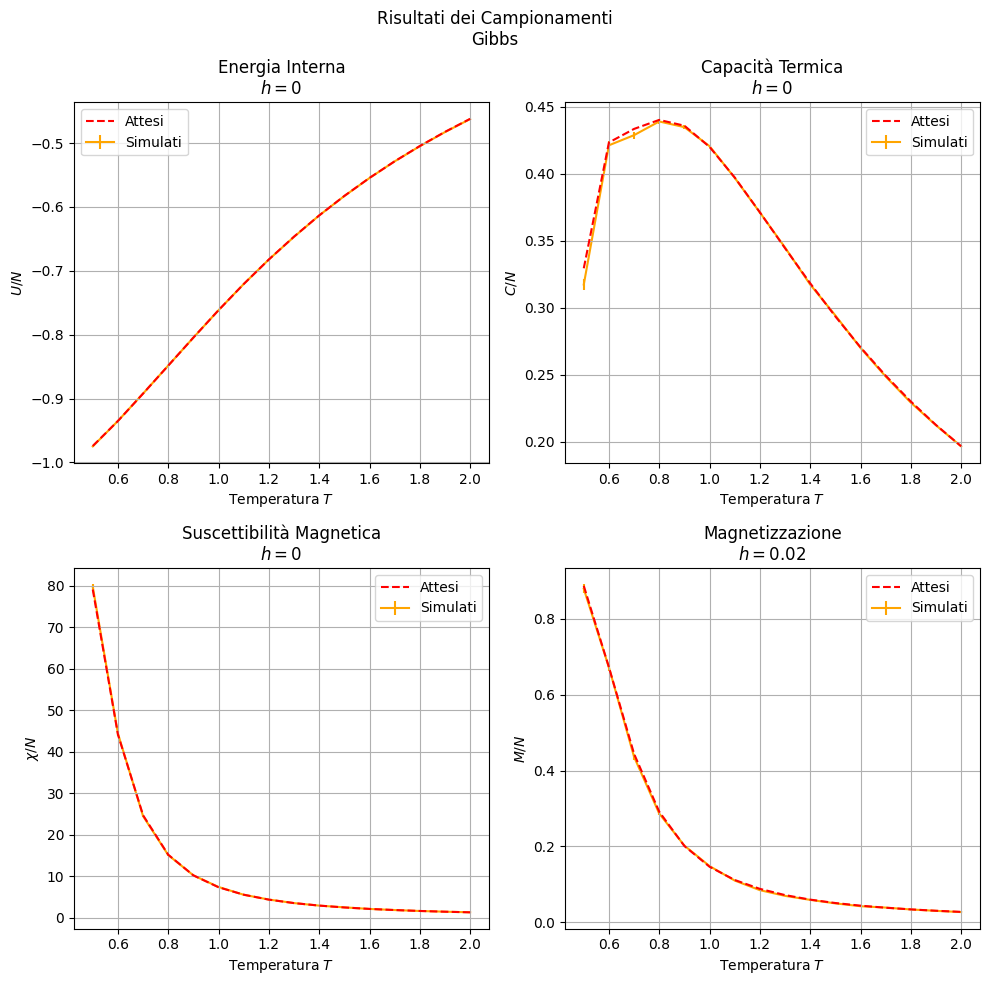

In [24]:
gibbs=np.array([
    np.array([np.loadtxt("ISING_1D/Gibbs/output_"+obs[j]+"_"+ str(np.round(T[i],1)) +".dat") for i in range(N)])
    for j in range(4)
])

fig, ax=plt.subplots(2,2,figsize=(10,10))
ax=np.reshape(ax,4)

for i in range(4):
    ax[i].errorbar(T,gibbs[i,:,-1,2],yerr=gibbs[i,:,-1,3],label="Simulati",color='orange',zorder=1)
    ax[i].plot(T,appo[i],label="Attesi",color='red', linestyle='dashed',zorder=2)

    ax[i].set(xlabel=r"Temperatura $T$", ylabel=symbles[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid(True)

fig.suptitle(f"Risultati dei Campionamenti\nGibbs")

plt.tight_layout()
plt.show()

Possiamo vedere che i grafici ottenuti sembrano seguire molto bene l'andamento dei valori attesi, però non possiamo ancora dire se siano compatibili o meno.

#### 1.2.4 Confronto tra le Simulazioni e con i Valori Attesi

Osserviamo di quanto si discostano i dati ottenuti da quelli ricavati analiticamente.

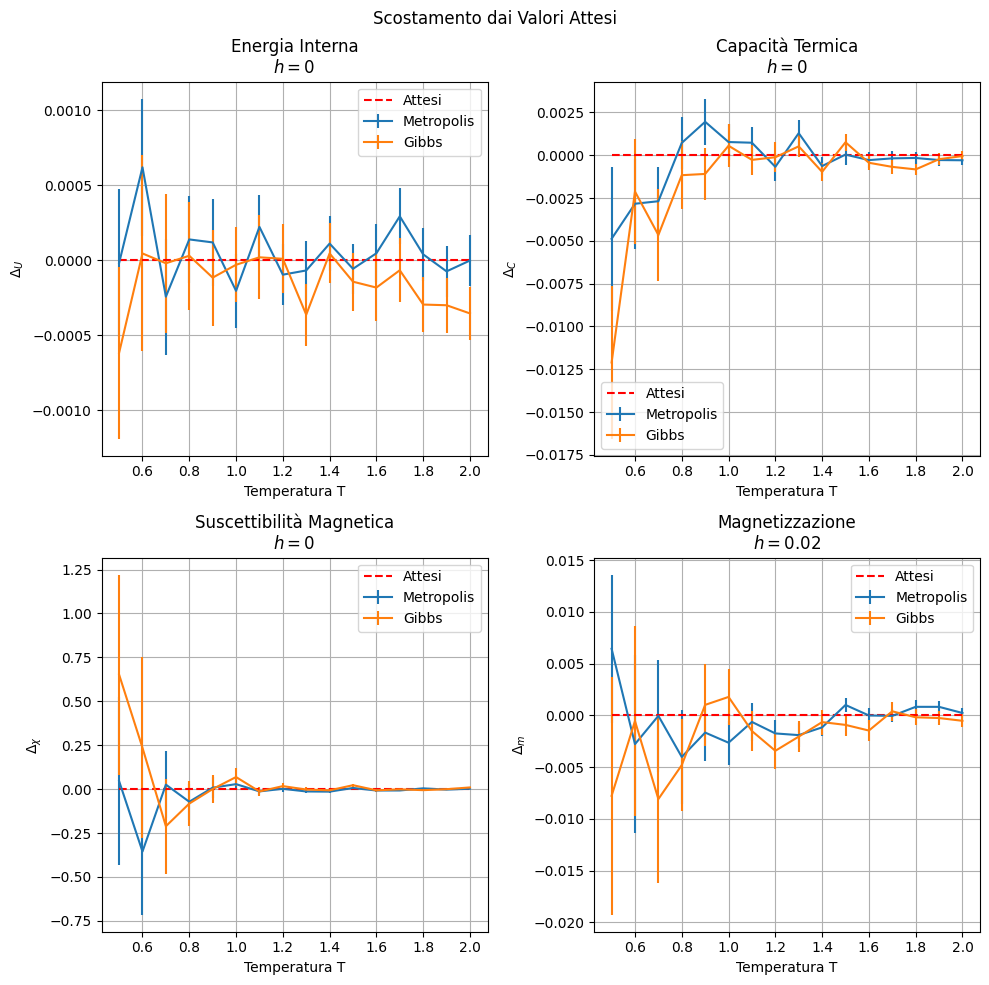

In [29]:
fig, ax=plt.subplots(2,2,figsize=(10,10))
ax=np.reshape(ax,4)

for j in range(4):
    ax[j].errorbar(T,metro[j,:,-1,2]-appo[j],yerr=metro[j,:,-1,3],label="Metropolis")
    ax[j].errorbar(T,gibbs[j,:,-1,2]-appo[j],yerr=gibbs[j,:,-1,3],label="Gibbs")
    ax[j].plot(T,np.zeros(N),color='red',linestyle='dashed',label="Attesi")
    
    #Parte estetica
    ax[j].grid(True)
    ax[j].legend()
    ax[j].set(xlabel="Temperatura T",ylabel=ytitle[j])
    ax[j].set_title(titles[j])

fig.suptitle("Scostamento dai Valori Attesi")
plt.tight_layout()
plt.show()


Notiamo che gli errori diminuiscono con l'aumentare della temperatura: questo è dovuto al fenomeno, precedentemente nominato, che la probabilità di cambiare uno spin aumenta con la temperatura, quindi è più facile campionare lo spazio degli eventi e questo perta ad un errore minore.  Anche in questo caso alcuni errori non sono distinguibili.

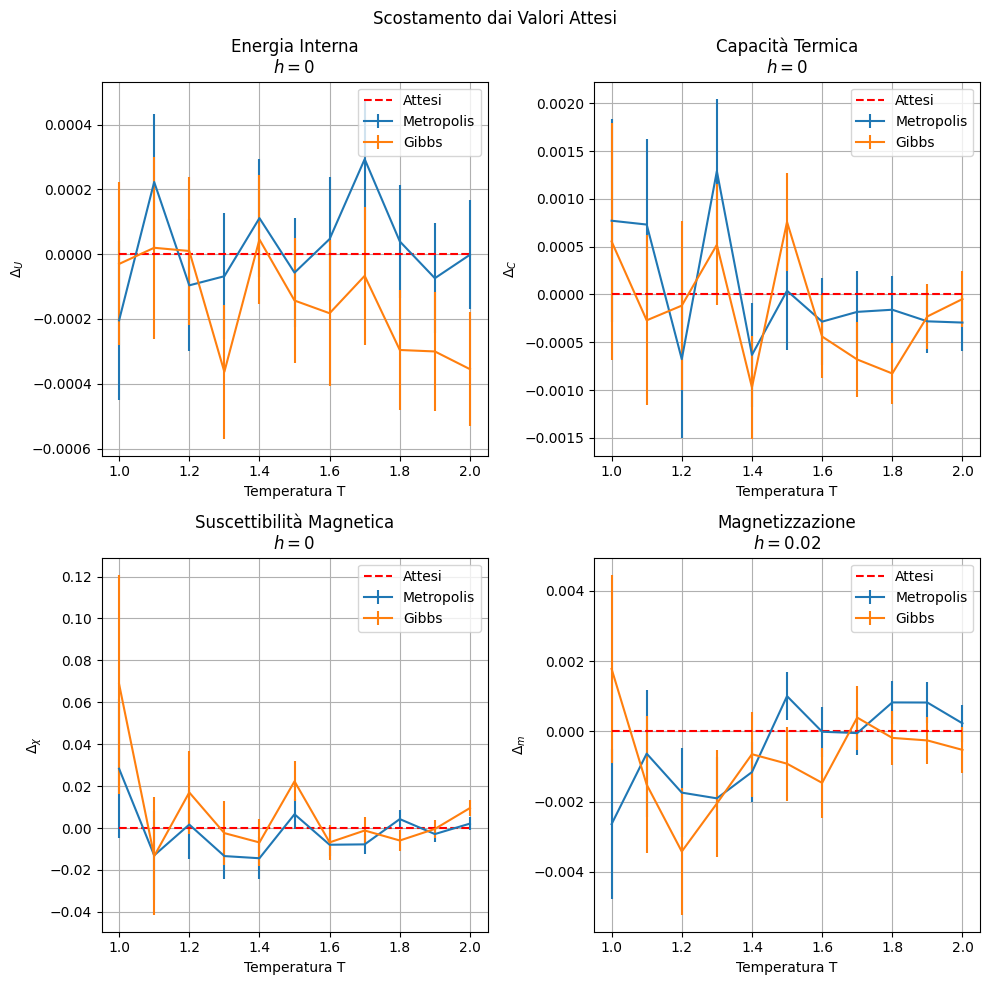

In [31]:
fig, ax=plt.subplots(2,2,figsize=(10,10))
ax=np.reshape(ax,4)

for j in range(4):
    ax[j].errorbar(T[5:],metro[j,5:,-1,2]-appo[j][5:],yerr=metro[j,5:,-1,3],label="Metropolis")
    ax[j].errorbar(T[5:],gibbs[j,5:,-1,2]-appo[j][5:],yerr=gibbs[j,5:,-1,3],label="Gibbs")
    ax[j].plot(T[5:],np.zeros(N-5),color='red',linestyle='dashed',label="Attesi")
    
    #Parte estetica
    ax[j].grid(True)
    ax[j].legend()
    ax[j].set(xlabel="Temperatura T",ylabel=ytitle[j])
    ax[j].set_title(titles[j])

fig.suptitle("Scostamento dai Valori Attesi")
plt.tight_layout()
plt.show()


Osservando il confronto di tutti i dati possiamo vedere che i nostri dati sono compatibili sia tra di loro sia con i valori attesi.